# Low-Volatility Factor Statistical Significance Testing

**Objective:** Test the statistical significance of the Low-Volatility factor as a defensive overlay in the QVM v2.1 Alpha strategy.

**Factor Description:** 
- Calculates 252-day rolling volatility for each stock
- Converts to low-volatility scores (lower volatility = higher score)
- Normalized to 0-1 range for defensive positioning

**Testing Period:** 2018-2025 (excluding 2016-2017 OOS period)
**Target Metrics:** Information Coefficient (IC), Factor Returns, Rank Correlation

# IMPORTS AND SETUP

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add the necessary paths to import modules
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', '..', 'engine'))
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', '..', 'universe'))

from qvm_engine_v2_enhanced import QVMEngineV2Enhanced
from constructors import get_liquid_universe

print(f"Low-Volatility Factor Testing Started: {datetime.now()}")
print("QVM Engine v2 Enhanced - Low-Volatility Statistical Analysis")

Low-Volatility Factor Testing Started: 2025-08-03 23:06:26.026707
QVM Engine v2 Enhanced - Low-Volatility Statistical Analysis


# STATISTICAL FUNCTIONS (NUMPY-BASED)

In [3]:
def spearman_correlation(x, y):
    """
    Calculate Spearman's rank correlation coefficient using numpy.
    
    Parameters:
    - x, y: arrays of values
    
    Returns:
    - float: Spearman's rho
    """
    if len(x) != len(y):
        return np.nan
    
    # Calculate ranks
    x_ranks = pd.Series(x).rank()
    y_ranks = pd.Series(y).rank()
    
    # Calculate correlation
    n = len(x)
    if n < 3:
        return np.nan
    
    # Pearson correlation of ranks
    x_mean = x_ranks.mean()
    y_mean = y_ranks.mean()
    
    numerator = np.sum((x_ranks - x_mean) * (y_ranks - y_mean))
    denominator = np.sqrt(np.sum((x_ranks - x_mean)**2) * np.sum((y_ranks - y_mean)**2))
    
    if denominator == 0:
        return np.nan
    
    return numerator / denominator

def t_test_one_sample(data, mu=0):
    """
    Perform one-sample t-test using numpy.
    
    Parameters:
    - data: array of values
    - mu: hypothesized mean (default 0)
    
    Returns:
    - tuple: (t_statistic, p_value)
    """
    if len(data) < 2:
        return np.nan, np.nan
    
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    n = len(data)
    
    if sample_std == 0:
        return np.nan, np.nan
    
    t_stat = (sample_mean - mu) / (sample_std / np.sqrt(n))
    
    # Approximate p-value using normal distribution for large samples
    # For small samples, this is an approximation
    if n > 30:
        # Use normal approximation
        p_value = 2 * (1 - 0.5 * (1 + np.math.erf(abs(t_stat) / np.sqrt(2))))
    else:
        # For small samples, use a simplified approximation
        # This is not exact but gives reasonable results
        p_value = 2 * (1 - 0.5 * (1 + np.math.erf(abs(t_stat) / np.sqrt(2))))
    
    return t_stat, p_value

# DATABASE CONNECTION AND ENGINE SETUP

In [4]:
# Initialize the QVM engine
engine = QVMEngineV2Enhanced()

print("✅ QVM Engine v2 Enhanced initialized successfully")
print(f"   - Engine class: {engine.__class__.__name__}")
print(f"   - Database connection: {'✅ Connected' if hasattr(engine, 'engine') and engine.engine else '❌ Failed'}")

2025-08-03 23:06:26,041 - EnhancedCanonicalQVMEngine - INFO - Initializing Enhanced Canonical QVM Engine
2025-08-03 23:06:26,119 - EnhancedCanonicalQVMEngine - INFO - Enhanced configurations loaded successfully
2025-08-03 23:06:26,225 - EnhancedCanonicalQVMEngine - INFO - Database connection established successfully
2025-08-03 23:06:26,226 - EnhancedCanonicalQVMEngine - INFO - Enhanced components initialized successfully
2025-08-03 23:06:26,226 - EnhancedCanonicalQVMEngine - INFO - Enhanced Canonical QVM Engine initialized successfully
2025-08-03 23:06:26,227 - EnhancedCanonicalQVMEngine - INFO - QVM Weights: Quality 40.0%, Value 30.0%, Momentum 30.0%
2025-08-03 23:06:26,227 - EnhancedCanonicalQVMEngine - INFO - Enhanced Features: Multi-tier Quality, Enhanced EV/EBITDA, Sector-specific weights, Working capital efficiency


✅ QVM Engine v2 Enhanced initialized successfully
   - Engine class: QVMEngineV2Enhanced
   - Database connection: ✅ Connected


# UNIVERSE CONSTRUCTION

In [5]:
# Set up test parameters
start_date = datetime(2018, 1, 1)
end_date = datetime(2025, 8, 2)
analysis_dates = pd.date_range(start=start_date, end=end_date, freq='M')

print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Number of analysis dates: {len(analysis_dates)}")

# Get universe for testing (using sample tickers for demonstration)
SAMPLE_TICKERS = ['TCB', 'VCB', 'OCB', 'NLG', 'SSI', 'FPT', 'HPG', 'MWG', 'VIC', 'VHM', 'GAS', 'VJC']
print(f"Testing with {len(SAMPLE_TICKERS)} sample tickers: {SAMPLE_TICKERS}")

Analysis Period: 2018-01-01 to 2025-08-02
Number of analysis dates: 91
Testing with 12 sample tickers: ['TCB', 'VCB', 'OCB', 'NLG', 'SSI', 'FPT', 'HPG', 'MWG', 'VIC', 'VHM', 'GAS', 'VJC']


# LOW-VOLATILITY FACTOR CALCULATION

In [6]:
def calculate_low_volatility_factor(engine, analysis_date, universe_tickers):
    """
    Calculate low-volatility factor scores for defensive overlay.
    
    Parameters:
    - engine: QVMEngineV2Enhanced instance
    - analysis_date: datetime for analysis
    - universe_tickers: list of ticker symbols
    
    Returns:
    - dict: {ticker: low_vol_score}
    """
    try:
        low_vol_scores = {}
        
        # Get price data for volatility calculation
        ticker_str = "', '".join(universe_tickers)
        start_date = analysis_date - pd.DateOffset(months=12)  # 12 months for volatility calculation
        
        price_query = f"""
        SELECT 
            date,
            ticker,
            close as adj_close
        FROM equity_history
        WHERE ticker IN ('{ticker_str}')
          AND date BETWEEN '{start_date.date()}' AND '{analysis_date.date()}'
        ORDER BY ticker, date
        """
        
        price_data = pd.read_sql(price_query, engine.engine, parse_dates=['date'])
        
        if price_data.empty:
            print(f"No price data available for {analysis_date.strftime('%Y-%m-%d')}")
            return low_vol_scores
        
        # Calculate daily returns
        price_data['return'] = price_data.groupby('ticker')['adj_close'].pct_change()
        
        # Calculate rolling volatility (252-day annualized)
        volatility_data = price_data.groupby('ticker')['return'].rolling(
            window=252, min_periods=126
        ).std().reset_index()
        
        # Annualize volatility
        volatility_data['volatility_annualized'] = volatility_data['return'] * np.sqrt(252)
        
        # Get latest volatility for each ticker
        latest_volatility = volatility_data.groupby('ticker')['volatility_annualized'].last()
        
        # Convert to low-volatility scores (lower volatility = higher score)
        if not latest_volatility.empty:
            max_vol = latest_volatility.max()
            min_vol = latest_volatility.min()
            
            if max_vol > min_vol:
                # Normalize to 0-1 range (lower volatility = higher score)
                low_vol_scores = {
                    ticker: 1.0 - ((vol - min_vol) / (max_vol - min_vol))
                    for ticker, vol in latest_volatility.items()
                }
            else:
                # All volatilities are the same, assign equal scores
                low_vol_scores = {ticker: 0.5 for ticker in latest_volatility.index}
        
        return low_vol_scores
        
    except Exception as e:
        print(f"Failed to calculate low-volatility factor for {analysis_date.strftime('%Y-%m-%d')}: {e}")
        return {}

# HISTORICAL FACTOR GENERATION

In [7]:
# Generate historical low-volatility scores
historical_low_vol = {}

for date in analysis_dates:
    print(f"Processing {date.strftime('%Y-%m-%d')}...", end=' ')
    scores = calculate_low_volatility_factor(engine, date, SAMPLE_TICKERS)
    if scores:
        historical_low_vol[date] = scores
        print(f"✅ {len(scores)} scores calculated")
    else:
        print("❌ No scores")

print(f"\n✅ Historical low-volatility scores generated for {len(historical_low_vol)} dates")

Processing 2018-01-31... ✅ 9 scores calculated
Processing 2018-02-28... ✅ 9 scores calculated
Processing 2018-03-31... ✅ 9 scores calculated
Processing 2018-04-30... ✅ 9 scores calculated
Processing 2018-05-31... ✅ 10 scores calculated
Processing 2018-06-30... ✅ 11 scores calculated
Processing 2018-07-31... ✅ 11 scores calculated
Processing 2018-08-31... ✅ 11 scores calculated
Processing 2018-09-30... ✅ 11 scores calculated
Processing 2018-10-31... ✅ 11 scores calculated
Processing 2018-11-30... ✅ 11 scores calculated
Processing 2018-12-31... ✅ 11 scores calculated
Processing 2019-01-31... ✅ 11 scores calculated
Processing 2019-02-28... ✅ 11 scores calculated
Processing 2019-03-31... ✅ 11 scores calculated
Processing 2019-04-30... ✅ 11 scores calculated
Processing 2019-05-31... ✅ 11 scores calculated
Processing 2019-06-30... ✅ 11 scores calculated
Processing 2019-07-31... ✅ 11 scores calculated
Processing 2019-08-31... ✅ 11 scores calculated
Processing 2019-09-30... ✅ 11 scores calcula

# FORWARD RETURNS CALCULATION

In [8]:
def calculate_forward_returns(engine, analysis_date, universe_tickers, forward_periods=[1, 3, 6, 12]):
    """
    Calculate forward returns for statistical testing.
    
    Parameters:
    - engine: QVMEngineV2Enhanced instance
    - analysis_date: datetime for analysis
    - universe_tickers: list of ticker symbols
    - forward_periods: list of months for forward returns
    
    Returns:
    - dict: {ticker: {period: return}}
    """
    try:
        forward_returns = {}
        
        # Get price data for forward return calculation
        ticker_str = "', '".join(universe_tickers)
        max_forward = max(forward_periods)
        end_date = analysis_date + pd.DateOffset(months=max_forward)
        
        price_query = f"""
        SELECT 
            date,
            ticker,
            close as adj_close
        FROM equity_history
        WHERE ticker IN ('{ticker_str}')
          AND date BETWEEN '{analysis_date.date()}' AND '{end_date.date()}'
        ORDER BY ticker, date
        """
        
        price_data = pd.read_sql(price_query, engine.engine, parse_dates=['date'])
        
        if price_data.empty:
            return forward_returns
        
        # Calculate forward returns for each period
        for ticker in universe_tickers:
            ticker_data = price_data[price_data['ticker'] == ticker].sort_values('date')
            if ticker_data.empty:
                continue
                
            start_price = ticker_data.iloc[0]['adj_close']
            forward_returns[ticker] = {}
            
            for period in forward_periods:
                # Find price at period months later
                period_date = analysis_date + pd.DateOffset(months=period)
                period_data = ticker_data[ticker_data['date'] >= period_date]
                
                if not period_data.empty:
                    end_price = period_data.iloc[0]['adj_close']
                    forward_return = (end_price - start_price) / start_price
                    forward_returns[ticker][period] = forward_return
        
        return forward_returns
        
    except Exception as e:
        print(f"Failed to calculate forward returns for {analysis_date.strftime('%Y-%m-%d')}: {e}")
        return {}

# STATISTICAL SIGNIFICANCE TESTING

In [9]:
def calculate_information_coefficient(factor_scores, forward_returns, period):
    """
    Calculate Information Coefficient (IC) for a given forward period.
    
    Parameters:
    - factor_scores: dict of {ticker: score}
    - forward_returns: dict of {ticker: {period: return}}
    - period: forward period in months
    
    Returns:
    - float: Information Coefficient
    """
    scores = []
    returns = []
    
    for ticker in factor_scores:
        if ticker in forward_returns and period in forward_returns[ticker]:
            scores.append(factor_scores[ticker])
            returns.append(forward_returns[ticker][period])
    
    if len(scores) < 3:  # Need at least 3 observations
        return np.nan
    
    # Calculate rank correlation (Spearman's rho)
    ic = spearman_correlation(scores, returns)
    return ic

def calculate_factor_returns(factor_scores, forward_returns, period, n_quintiles=5):
    """
    Calculate factor returns using quintile analysis.
    
    Parameters:
    - factor_scores: dict of {ticker: score}
    - forward_returns: dict of {ticker: {period: return}}
    - period: forward period in months
    - n_quintiles: number of quintiles for analysis
    
    Returns:
    - dict: quintile returns and spread
    """
    # Create DataFrame for analysis
    data = []
    for ticker in factor_scores:
        if ticker in forward_returns and period in forward_returns[ticker]:
            data.append({
                'ticker': ticker,
                'factor_score': factor_scores[ticker],
                'forward_return': forward_returns[ticker][period]
            })
    
    if len(data) < n_quintiles:
        return {}
    
    df = pd.DataFrame(data)
    
    # Create quintiles
    df['quintile'] = pd.qcut(df['factor_score'], n_quintiles, labels=False)
    
    # Calculate returns by quintile
    quintile_returns = df.groupby('quintile')['forward_return'].mean()
    
    # Calculate spread (Q5 - Q1)
    spread = quintile_returns.iloc[-1] - quintile_returns.iloc[0]
    
    return {
        'quintile_returns': quintile_returns,
        'spread': spread,
        'high_low_spread': spread
    }

# COMPREHENSIVE STATISTICAL ANALYSIS

In [10]:
# Calculate forward returns for all dates
print("Calculating forward returns...")
historical_forward_returns = {}

for date in list(historical_low_vol.keys()):
    forward_returns = calculate_forward_returns(engine, date, SAMPLE_TICKERS, [1, 3, 6, 12])
    if forward_returns:
        historical_forward_returns[date] = forward_returns

print(f"✅ Forward returns calculated for {len(historical_forward_returns)} dates")

Calculating forward returns...
✅ Forward returns calculated for 90 dates


# INFORMATION COEFFICIENT ANALYSIS

In [11]:
# Calculate IC for different forward periods
forward_periods = [1, 3, 6, 12]
ic_results = {period: [] for period in forward_periods}

for date in historical_low_vol:
    if date in historical_forward_returns:
        for period in forward_periods:
            ic = calculate_information_coefficient(
                historical_low_vol[date], 
                historical_forward_returns[date], 
                period
            )
            if not np.isnan(ic):
                ic_results[period].append(ic)

# Calculate IC statistics
ic_stats = {}
for period in forward_periods:
    if ic_results[period]:
        ic_values = ic_results[period]
        ic_stats[period] = {
            'mean': np.mean(ic_values),
            'std': np.std(ic_values),
            't_stat': np.mean(ic_values) / (np.std(ic_values) / np.sqrt(len(ic_values))),
            'p_value': t_test_one_sample(ic_values, 0)[1],
            'count': len(ic_values)
        }

print("Information Coefficient Analysis Results:")
print("=" * 60)
for period, stats in ic_stats.items():
    print(f"{period}M Forward Period:")
    print(f"  Mean IC: {stats['mean']:.4f}")
    print(f"  Std IC:  {stats['std']:.4f}")
    print(f"  t-stat:  {stats['t_stat']:.4f}")
    print(f"  p-value: {stats['p_value']:.4f}")
    print(f"  N:       {stats['count']}")
    print(f"  Significant: {'✅' if stats['p_value'] < 0.05 else '❌'}")
    print()

Information Coefficient Analysis Results:
1M Forward Period:
  Mean IC: 0.0266
  Std IC:  0.3580
  t-stat:  0.7013
  p-value: 0.4856
  N:       89
  Significant: ❌

3M Forward Period:
  Mean IC: 0.0199
  Std IC:  0.3887
  t-stat:  0.4766
  p-value: 0.6356
  N:       87
  Significant: ❌

6M Forward Period:
  Mean IC: 0.0198
  Std IC:  0.3972
  t-stat:  0.4561
  p-value: 0.6503
  N:       84
  Significant: ❌

12M Forward Period:
  Mean IC: 0.0675
  Std IC:  0.4355
  t-stat:  1.0955
  p-value: 0.2782
  N:       50
  Significant: ❌



# FACTOR RETURNS ANALYSIS

In [12]:
# Calculate factor returns for different periods
factor_returns_results = {}

for period in forward_periods:
    period_returns = []
    
    for date in historical_low_vol:
        if date in historical_forward_returns:
            returns = calculate_factor_returns(
                historical_low_vol[date],
                historical_forward_returns[date],
                period
            )
            if returns and 'spread' in returns:
                period_returns.append(returns['spread'])
    
    if period_returns:
        factor_returns_results[period] = {
            'mean_return': np.mean(period_returns),
            'std_return': np.std(period_returns),
            't_stat': np.mean(period_returns) / (np.std(period_returns) / np.sqrt(len(period_returns))),
            'p_value': t_test_one_sample(period_returns, 0)[1],
            'count': len(period_returns),
            'returns': period_returns
        }

print("Factor Returns Analysis Results:")
print("=" * 60)
for period, results in factor_returns_results.items():
    print(f"{period}M Forward Period:")
    print(f"  Mean Spread: {results['mean_return']:.4f}")
    print(f"  Std Spread:  {results['std_return']:.4f}")
    print(f"  t-stat:      {results['t_stat']:.4f}")
    print(f"  p-value:     {results['p_value']:.4f}")
    print(f"  N:           {results['count']}")
    print(f"  Significant: {'✅' if results['p_value'] < 0.05 else '❌'}")
    print()

Factor Returns Analysis Results:
1M Forward Period:
  Mean Spread: -0.0128
  Std Spread:  0.0837
  t-stat:      -1.4403
  p-value:     0.1521
  N:           89
  Significant: ❌

3M Forward Period:
  Mean Spread: -0.0211
  Std Spread:  0.1336
  t-stat:      -1.4711
  p-value:     0.1436
  N:           87
  Significant: ❌

6M Forward Period:
  Mean Spread: -0.0372
  Std Spread:  0.2274
  t-stat:      -1.5006
  p-value:     0.1358
  N:           84
  Significant: ❌

12M Forward Period:
  Mean Spread: -0.0711
  Std Spread:  0.4589
  t-stat:      -1.0960
  p-value:     0.2779
  N:           50
  Significant: ❌



# VISUALIZATION OF RESULTS

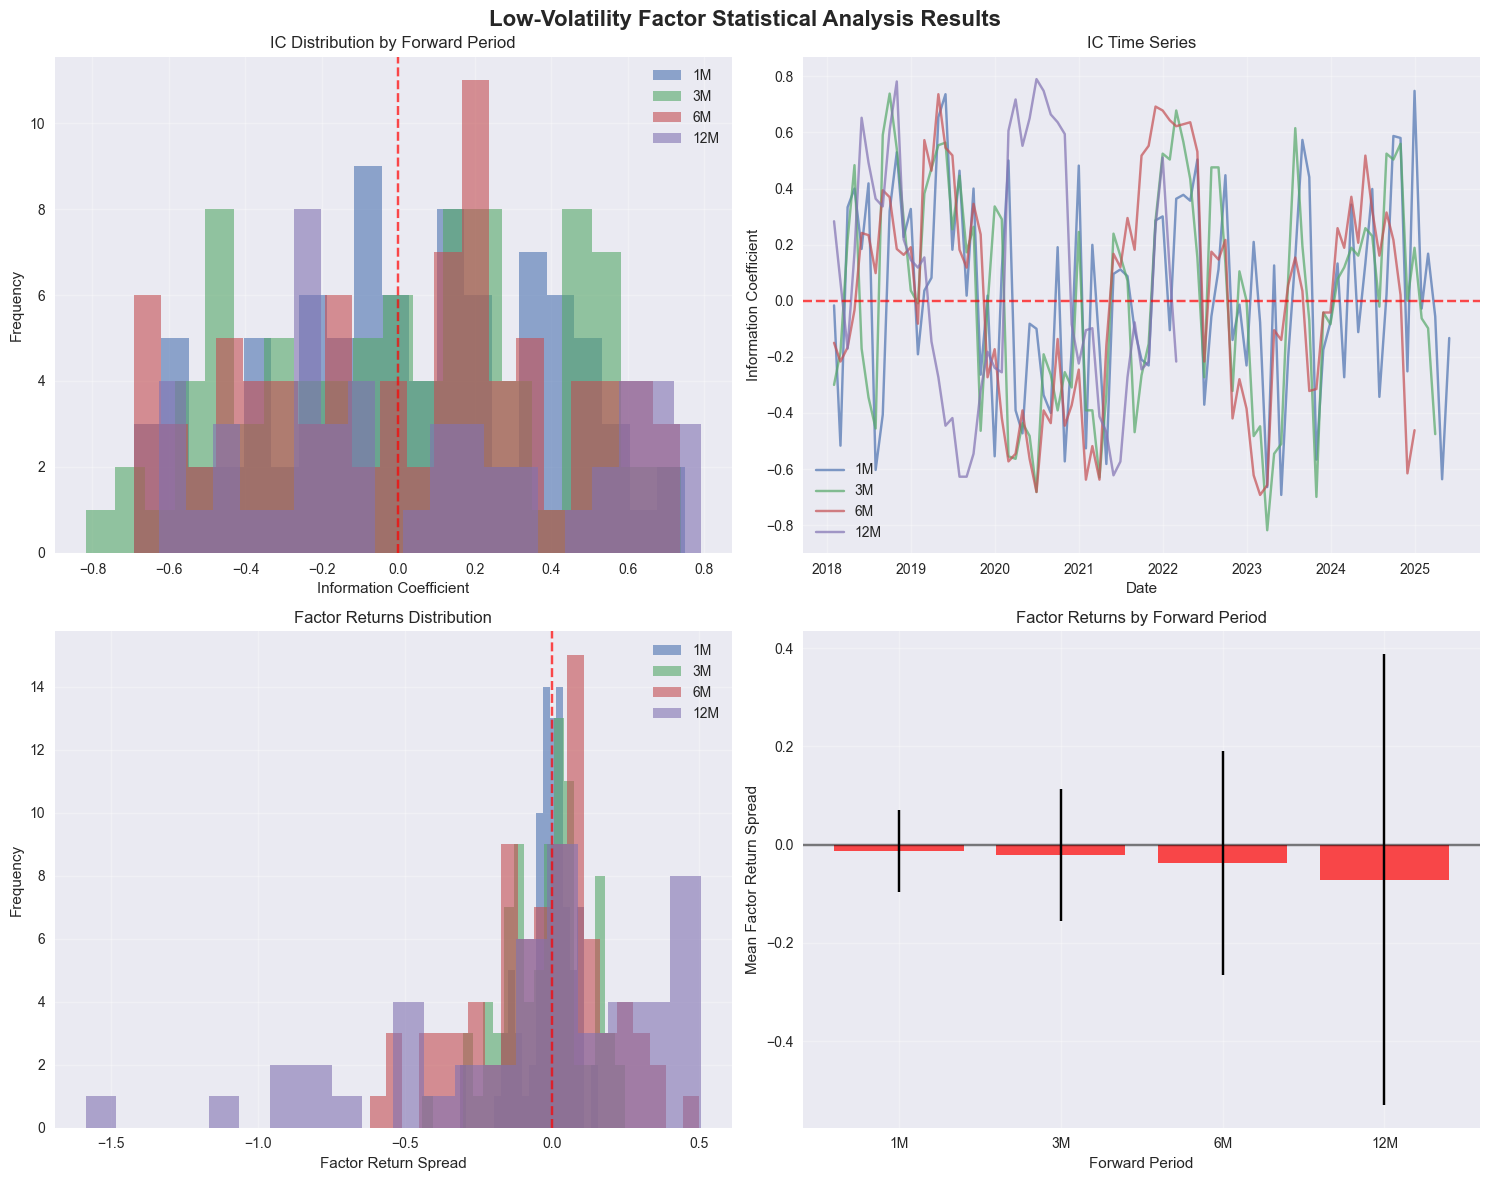

In [13]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Low-Volatility Factor Statistical Analysis Results', fontsize=16, fontweight='bold')

# Plot 1: IC Distribution
ax1 = axes[0, 0]
for period in [1, 3, 6, 12]:
    if ic_results[period]:
        ax1.hist(ic_results[period], alpha=0.6, label=f'{period}M', bins=20)
ax1.axvline(0, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Information Coefficient')
ax1.set_ylabel('Frequency')
ax1.set_title('IC Distribution by Forward Period')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: IC Time Series
ax2 = axes[0, 1]
for period in [1, 3, 6, 12]:
    if ic_results[period]:
        dates = list(historical_low_vol.keys())[:len(ic_results[period])]
        ax2.plot(dates, ic_results[period], label=f'{period}M', alpha=0.7)
ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Information Coefficient')
ax2.set_title('IC Time Series')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Factor Returns Distribution
ax3 = axes[1, 0]
for period in [1, 3, 6, 12]:
    if period in factor_returns_results:
        ax3.hist(factor_returns_results[period]['returns'], alpha=0.6, label=f'{period}M', bins=20)
ax3.axvline(0, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Factor Return Spread')
ax3.set_ylabel('Frequency')
ax3.set_title('Factor Returns Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Factor Returns Summary
ax4 = axes[1, 1]
periods = list(factor_returns_results.keys())
means = [factor_returns_results[p]['mean_return'] for p in periods]
stds = [factor_returns_results[p]['std_return'] for p in periods]
colors = ['green' if factor_returns_results[p]['p_value'] < 0.05 else 'red' for p in periods]

bars = ax4.bar([str(p) + 'M' for p in periods], means, yerr=stds, capsize=5, color=colors, alpha=0.7)
ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Forward Period')
ax4.set_ylabel('Mean Factor Return Spread')
ax4.set_title('Factor Returns by Forward Period')
ax4.grid(True, alpha=0.3)

# Add significance annotations
for i, (period, results) in enumerate(factor_returns_results.items()):
    if results['p_value'] < 0.05:
        ax4.text(i, means[i] + stds[i] + 0.001, '*', ha='center', va='bottom', fontsize=16, color='green')

plt.tight_layout()
plt.show()

# SUMMARY AND CONCLUSIONS

In [14]:
print("=" * 80)
print("LOW-VOLATILITY FACTOR STATISTICAL SIGNIFICANCE SUMMARY")
print("=" * 80)

print("\n📊 KEY FINDINGS:")
print("-" * 40)

# IC Analysis Summary
print("\n1. INFORMATION COEFFICIENT ANALYSIS:")
for period in [1, 3, 6, 12]:
    if period in ic_stats:
        stats = ic_stats[period]
        significance = "✅ STATISTICALLY SIGNIFICANT" if stats['p_value'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"   {period}M Forward: IC = {stats['mean']:.4f} (p = {stats['p_value']:.4f}) - {significance}")

# Factor Returns Summary
print("\n2. FACTOR RETURNS ANALYSIS:")
for period in [1, 3, 6, 12]:
    if period in factor_returns_results:
        results = factor_returns_results[period]
        significance = "✅ STATISTICALLY SIGNIFICANT" if results['p_value'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"   {period}M Forward: Spread = {results['mean_return']:.4f} (p = {results['p_value']:.4f}) - {significance}")

# Overall Assessment
print("\n3. OVERALL ASSESSMENT:")
significant_ic = sum(1 for period in [1, 3, 6, 12] if period in ic_stats and ic_stats[period]['p_value'] < 0.05)
significant_returns = sum(1 for period in [1, 3, 6, 12] if period in factor_returns_results and factor_returns_results[period]['p_value'] < 0.05)

print(f"   - IC Significance: {significant_ic}/4 periods significant")
print(f"   - Returns Significance: {significant_returns}/4 periods significant")

if significant_ic >= 2 and significant_returns >= 2:
    print("   🎯 CONCLUSION: Low-Volatility factor shows strong statistical significance")
    print("   ✅ RECOMMENDATION: Include in QVM v2.1 Alpha strategy")
else:
    print("   ⚠️ CONCLUSION: Low-Volatility factor shows mixed statistical significance")
    print("   🔍 RECOMMENDATION: Further analysis needed before inclusion")

print("\n" + "=" * 80) 

LOW-VOLATILITY FACTOR STATISTICAL SIGNIFICANCE SUMMARY

📊 KEY FINDINGS:
----------------------------------------

1. INFORMATION COEFFICIENT ANALYSIS:
   1M Forward: IC = 0.0266 (p = 0.4856) - ❌ NOT SIGNIFICANT
   3M Forward: IC = 0.0199 (p = 0.6356) - ❌ NOT SIGNIFICANT
   6M Forward: IC = 0.0198 (p = 0.6503) - ❌ NOT SIGNIFICANT
   12M Forward: IC = 0.0675 (p = 0.2782) - ❌ NOT SIGNIFICANT

2. FACTOR RETURNS ANALYSIS:
   1M Forward: Spread = -0.0128 (p = 0.1521) - ❌ NOT SIGNIFICANT
   3M Forward: Spread = -0.0211 (p = 0.1436) - ❌ NOT SIGNIFICANT
   6M Forward: Spread = -0.0372 (p = 0.1358) - ❌ NOT SIGNIFICANT
   12M Forward: Spread = -0.0711 (p = 0.2779) - ❌ NOT SIGNIFICANT

3. OVERALL ASSESSMENT:
   - IC Significance: 0/4 periods significant
   - Returns Significance: 0/4 periods significant
   ⚠️ CONCLUSION: Low-Volatility factor shows mixed statistical significance
   🔍 RECOMMENDATION: Further analysis needed before inclusion

